<a href="https://colab.research.google.com/github/xhxuciedu/cs273p/blob/main/_downloads/9cf2d4ead514e661e20d2070c9bf7324/transformer_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Language Modeling with ``nn.Transformer`` and torchtext

This is a tutorial on training a model to predict the next word in a sequence using the
[nn.Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)_ module.

The PyTorch 1.2 release includes a standard transformer module based on the
paper [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf)_.
Compared to Recurrent Neural Networks (RNNs), the transformer model has proven
to be superior in quality for many sequence-to-sequence tasks while being more
parallelizable. The ``nn.Transformer`` module relies entirely on an attention
mechanism (implemented as
[nn.MultiheadAttention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)_)
to draw global dependencies between input and output. The ``nn.Transformer``
module is highly modularized such that a single component (e.g.,
[nn.TransformerEncoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)_)
can be easily adapted/composed.

<img src="file://../_static/img/transformer_architecture.jpg">


## Define the model




In this tutorial, we train a ``nn.TransformerEncoder`` model on a
causal language modeling task. Please note that this tutorial does not cover
the training of [nn.TransformerDecoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html#torch.nn.TransformerDecoder)_, as depicted in
the right half of the diagram above. The language modeling task is to assign a
probability for the likelihood of a given word (or a sequence of words)
to follow a sequence of words. A sequence of tokens are passed to the embedding
layer first, followed by a positional encoding layer to account for the order
of the word (see the next paragraph for more details). The
``nn.TransformerEncoder`` consists of multiple layers of
[nn.TransformerEncoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html)_.
Along with the input sequence, a square attention mask is required because the
self-attention layers in ``nn.TransformerDecoder`` are only allowed to attend
the earlier positions in the sequence. For the language modeling task, any
tokens on the future positions should be masked.  This masking, combined with fact that
the output embeddings are offset with later positions ensures that the
predictions for position i can depend only on the known outputs at positions less than i.
To produce a probability  distribution over output words, the output of the ``nn.TransformerEncoder``
model is passed through a linear layer to output unnormalized logits.
The log-softmax function isn't applied here due to the later use of
[CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)_,
which requires the inputs to be unnormalized logits.




In [2]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.embedding = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.linear = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor = None) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        if src_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            src_mask = nn.Transformer.generate_square_subsequent_mask(len(src)).to(device)
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        return output

``PositionalEncoding`` module injects some information about the
relative or absolute position of the tokens in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies.




In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## Load and batch data




This tutorial uses ``torchtext`` to generate Wikitext-2 dataset.
To access torchtext datasets, please install torchdata following instructions at https://github.com/pytorch/data.
%%

In [4]:
%%bash
pip install portalocker
pip install torchdata

The vocab object is built based on the train dataset and is used to numericalize
tokens into tensors. Wikitext-2 represents rare tokens as `<unk>`.

Given a 1-D vector of sequential data, ``batchify()`` arranges the data
into ``batch_size`` columns. If the data does not divide evenly into
``batch_size`` columns, then the data is trimmed to fit. For instance, with
the alphabet as the data (total length of 26) and ``batch_size=4``, we would
divide the alphabet into sequences of length 6, resulting in 4 of such sequences.

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

Batching enables more parallelizable processing. However, batching means that
the model treats each column independently; for example, the dependence of
``G`` and ``F`` can not be learned in the example above.




In [5]:
# # Download and load the Wikitext-2 dataset
# train_iter = PennTreebank(split='train')


# # Iterate through the training data
# i = 0
# for line in train_iter:
#     print(line)  # Each 'line' is a string containing one line of the dataset
#     i+= 1
#     if i>10: break


In [6]:
from torchtext.datasets import PennTreebank
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = PennTreebank(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# ``train_iter`` was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = PennTreebank()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into ``bsz`` separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Arguments:
        data: Tensor, shape ``[N]``
        bsz: int, batch size

    Returns:
        Tensor of shape ``[N // bsz, bsz]``
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape ``[seq_len, batch_size]``
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

### Functions to generate input and target sequence




``get_batch()`` generates a pair of input-target sequences for
the transformer model. It subdivides the source data into chunks of
length ``bptt``. For the language modeling task, the model needs the
following words as ``Target``. For example, with a ``bptt`` value of 2,
we’d get the following two Variables for ``i`` = 0:

<img src="file://../_static/img/transformer_input_target.png">

It should be noted that the chunks are along dimension 0, consistent
with the ``S`` dimension in the Transformer model. The batch dimension
``N`` is along dimension 1.




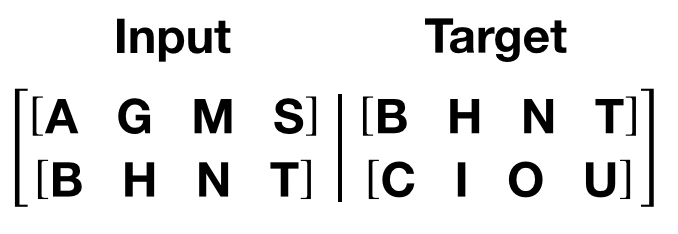

In [7]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape ``[full_seq_len, batch_size]``
        i: int

    Returns:
        tuple (data, target), where data has shape ``[seq_len, batch_size]`` and
        target has shape ``[seq_len * batch_size]``
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

## Initiate an instance




The model hyperparameters are defined below. The ``vocab`` size is
equal to the length of the vocab object.




In [8]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Run the model




We use [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)_
with the [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)_
(stochastic gradient descent) optimizer. The learning rate is initially set to
5.0 and follows a [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)_
schedule. During training, we use [nn.utils.clip_grad_norm\_](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)_
to prevent gradients from exploding.




In [9]:
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        output = model(data)
        output_flat = output.view(-1, ntokens)
        loss = criterion(output_flat, targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            output = model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [10]:
best_val_loss = float('inf')
epochs = 1

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(model)
        val_loss = evaluate(model, val_data)
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()
    model.load_state_dict(torch.load(best_model_params_path)) # load best model states

| epoch   1 |   200/ 1320 batches | lr 5.00 | ms/batch 309.73 | loss  7.19 | ppl  1322.06
| epoch   1 |   400/ 1320 batches | lr 5.00 | ms/batch 287.49 | loss  6.08 | ppl   437.27
| epoch   1 |   600/ 1320 batches | lr 5.00 | ms/batch 278.14 | loss  5.84 | ppl   343.95
| epoch   1 |   800/ 1320 batches | lr 5.00 | ms/batch 283.09 | loss  5.67 | ppl   289.49
| epoch   1 |  1000/ 1320 batches | lr 5.00 | ms/batch 272.91 | loss  5.59 | ppl   268.56
| epoch   1 |  1200/ 1320 batches | lr 5.00 | ms/batch 281.56 | loss  5.48 | ppl   240.46
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 386.25s | valid loss  5.46 | valid ppl   235.60
-----------------------------------------------------------------------------------------


## Evaluate the best model on the test dataset




In [11]:
test_loss = evaluate(model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.43 | test ppl   227.19
